In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os
import re


import pickle
from etcpy import etc
from etcpy import tempDep
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [3]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params_new_tagged.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[0].set_index('Ts').rename_axis(None)
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source,TmTag
P77467,306.15,10,262,328.717325,7.588735,NaN,-4000,1000,predicted,Mean
P76077,311.15,10,309,328.717325,7.588735,NaN,-4000,1000,predicted,Mean
P76078,310.15,10,95,328.717325,7.588735,NaN,-4000,1000,BullShit,Mean
P76079,309.15,10,248,328.717325,7.588735,NaN,-4000,1000,predicted,Mean
P76081,310.15,10,356,328.717325,7.588735,NaN,-4000,1000,BullShit,Mean
...,...,...,...,...,...,...,...,...,...,...
P0AG80,313.15,10,438,329.166303,4.070000,330.45,-4000,1000,predicted,Exp
P77718,307.15,10,482,319.125751,4.070000,320.15,-4000,1000,predicted,Exp
P0A6D5,308.15,10,288,328.762604,7.710000,NaN,-4000,1000,predicted,Mean
standard,308.15,10,272,328.762604,7.710000,NaN,-4000,1000,BullShit,Mean


In [4]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    #mae = GEMS.addNGAMreaction(mae)
    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    match = re.compile('usage_prot_*', re.IGNORECASE)
    for react in mae.reactions:
        if match.match(react.id) and react.lower_bound != -1000:
            ori_lb = react.lower_bound
            react.lower_bound = ori_lb*2.5

    
    try: 
        rae, gae, oae, cae, aae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    rexp = dfae_batch['r'].values
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae), 'carbonDioxide': np.array(cae), 'acetate': np.array(aae)}, r2_score(rexp,rae), MSE(rexp,rae)

In [5]:
rae, score, mse = aerobic(params)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-06
NGAM is: 3.23
Growth at  20.153299075508016 is:  0.7080752581283789
NGAM is: 3.23
Growth at  23.00151111308503 is:  0.9278807395791525
NGAM is: 3.666948749964016
Growth at  26.331896319367047 is:  1.1821305426490294
NGAM is: 4.228097946953468
Growth at  28.251819864188008 is:  1.320015854878182
NGAM is: 4.675583853845237
Growth at  29.99421176442104 is:  1.43302675464456
NGAM is: 5.047267123847456
Growth at  31.62212188446705 is:  1.524047508747879
NGAM is: 5.44939156263788
Growth at  33.61728633658504 is:  1.4312751810995925
NGAM is: 5.950125048399887
Growth at  36.55299482796005 is:  1.263472177934689
NGAM is: 6.237403245621997
Growth at  38.54155004207803 is:  1.1369473225097833
NGAM is: 6.449817187489966
Growth at  40.20094365636703 is:  1.028125908814962
NGAM is: 6.681009354243395
Growth at  42.23876395989504 is:  0.8949592540948933
NGAM is: 6.9000236503978725
Growth at  44.453491097574044 i

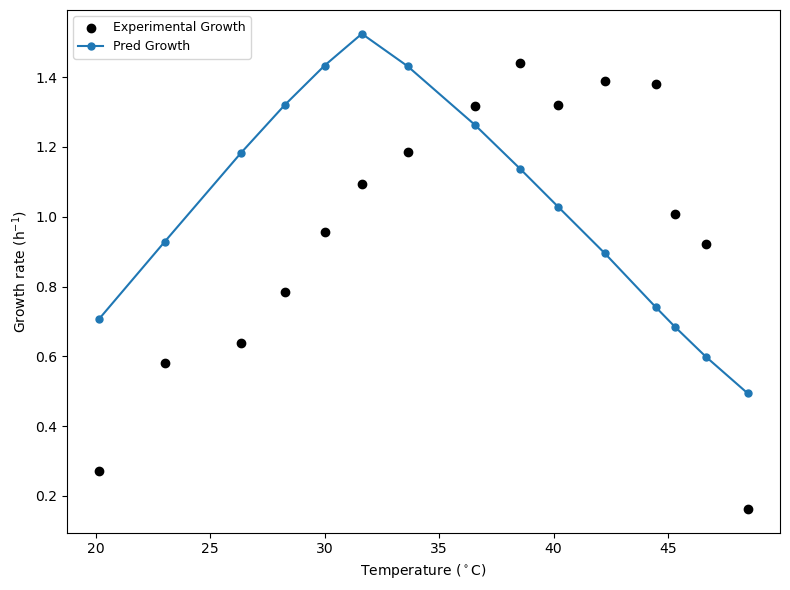

In [6]:
plt.figure()
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Growth rate (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
#plt.savefig('../results/plots/onlyBounds.svg')
plt.show()